# XG Boost Regressor

## Importing the libraries

In [576]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Importing the dataset

In [577]:
# pyspark_df = spark.table("sd_bdc_demo.xgboost_regression.1_salesforce_updated_data")
# pyspark_df.display()
# df = pyspark_df.toPandas()

In [578]:
# Load csv file
df = pd.read_csv("1_salesforce_updated_data/1_salesforce_updated_data.csv")

In [579]:
print(df)

    Sales_Order                 Stage  Amount  Probability    Sales_Person  \
0          5708           Closed Lost  255000            0  Alex Rodriguez   
1          5709       Decision Makers  315000           70   Sarah Johnson   
2          5710  Proposal/Price Quote  275000           65   Michael Chang   
3          5711            Closed Won  135000          100     Emma Wilson   
4          5712    Negotiation/Review  325000           85  David Martinez   
..          ...                   ...     ...          ...             ...   
91         5799   Perception Analysis  475000           25  Alex Rodriguez   
92         5800     Value Proposition  115000           40   Sarah Johnson   
93         5801         Qualification   95000           20   Michael Chang   
94         5802            Closed Won   68000          100     Emma Wilson   
95         5803        Needs Analysis  185000           35  David Martinez   

      Company_Industry              Contact_Title          Type

In [580]:
print(df.shape)

(96, 11)


In [581]:
print(df.columns)

Index(['Sales_Order', 'Stage', 'Amount', 'Probability', 'Sales_Person',
       'Company_Industry', 'Contact_Title', 'Type', 'Lead_Source', 'State',
       'days_to_close'],
      dtype='object')


## Encoding categorical data

### Encoding the Independent Variable

In [582]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
categorical_cols = [
    'Sales_Person',
    'Company_Industry',
    'Contact_Title',
    'Type',
    'Lead_Source',
    'State'
]

# Save encoder for later use
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  


In [583]:
print(df_encoded.head())

   Sales_Order                 Stage  Amount  Probability  Sales_Person  \
0         5708           Closed Lost  255000            0             0   
1         5709       Decision Makers  315000           70             4   
2         5710  Proposal/Price Quote  275000           65             3   
3         5711            Closed Won  135000          100             2   
4         5712    Negotiation/Review  325000           85             1   

   Company_Industry  Contact_Title  Type  Lead_Source  State  days_to_close  
0                12             29     0            5     42             45  
1                11             20     0           14     23             97  
2                 8              8     0            6     39            117  
3                19             28     0           16     31             36  
4                15             41     0           10     29             92  


In [584]:
print(df_encoded.shape)

(96, 11)


In [585]:
print(df_encoded.columns)

Index(['Sales_Order', 'Stage', 'Amount', 'Probability', 'Sales_Person',
       'Company_Industry', 'Contact_Title', 'Type', 'Lead_Source', 'State',
       'days_to_close'],
      dtype='object')


## Split two Data Frame for Independent Features & Dependent Columns

In [586]:
df_independent = df_encoded.drop(columns=['Probability'])
X = df_independent
df_dependent = df_encoded[['Probability']]
y = df_dependent

In [587]:
print(df_independent.head())

   Sales_Order                 Stage  Amount  Sales_Person  Company_Industry  \
0         5708           Closed Lost  255000             0                12   
1         5709       Decision Makers  315000             4                11   
2         5710  Proposal/Price Quote  275000             3                 8   
3         5711            Closed Won  135000             2                19   
4         5712    Negotiation/Review  325000             1                15   

   Contact_Title  Type  Lead_Source  State  days_to_close  
0             29     0            5     42             45  
1             20     0           14     23             97  
2              8     0            6     39            117  
3             28     0           16     31             36  
4             41     0           10     29             92  


In [588]:
print(df_independent.shape)

(96, 10)


In [589]:
print(df_dependent.head())

   Probability
0            0
1           70
2           65
3          100
4           85


In [590]:
print(df_dependent.shape)

(96, 1)


## Splitting the dataset into the Training set and Test set (`Closed Won` & `Closed Lost` = `train`)

In [591]:
# Define which rows go into train and test based on 'Stage'
is_train = df_encoded['Stage'].isin(['Closed Won', 'Closed Lost'])

# Split X
X_train = X[is_train] 
X_test = X[~is_train]

# Split y
y_train = y[is_train]
y_test = y[~is_train]  


In [592]:
print(X_train.head())

    Sales_Order        Stage  Amount  Sales_Person  Company_Industry  \
0          5708  Closed Lost  255000             0                12   
3          5711   Closed Won  135000             2                19   
8          5716   Closed Won  235000             2                12   
12         5720   Closed Won  225000             2                 8   
17         5725   Closed Won  175000             2                12   

    Contact_Title  Type  Lead_Source  State  days_to_close  
0              29     0            5     42             45  
3              28     0           16     31             36  
8               4     2            5     38             36  
12             11     2            4     24             38  
17             48     2            5     21             40  


In [593]:
print(X_train.shape)

(25, 10)


In [594]:
print(X_test.head())

   Sales_Order                 Stage  Amount  Sales_Person  Company_Industry  \
1         5709       Decision Makers  315000             4                11   
2         5710  Proposal/Price Quote  275000             3                 8   
4         5712    Negotiation/Review  325000             1                15   
5         5713   Perception Analysis  345000             0                23   
6         5714     Value Proposition  195000             4                 6   

   Contact_Title  Type  Lead_Source  State  days_to_close  
1             20     0           14     23             97  
2              8     0            6     39            117  
4             41     0           10     29             92  
5             32     0           14     33            204  
6             20     0            2     41            158  


In [595]:
print(X_test.shape)

(71, 10)


In [596]:
print(y_train.head())

    Probability
0             0
3           100
8           100
12          100
17          100


In [597]:
print(y_train.shape)

(25, 1)


In [598]:
print(y_test.head())

   Probability
1           70
2           65
4           85
5           20
6           45


In [599]:
print(y_test.shape)

(71, 1)


## Feature Scaling
- As this is a tree based model, no need to do feature scaling

## Removing `Sales_Order` & `Stage` in `X_train` & `X_test`

In [600]:
X_train_new = X_train.drop(columns=['Sales_Order', 'Stage', 'Sales_Person'])


In [601]:
print(X_train_new.head())

    Amount  Company_Industry  Contact_Title  Type  Lead_Source  State  \
0   255000                12             29     0            5     42   
3   135000                19             28     0           16     31   
8   235000                12              4     2            5     38   
12  225000                 8             11     2            4     24   
17  175000                12             48     2            5     21   

    days_to_close  
0              45  
3              36  
8              36  
12             38  
17             40  


In [602]:
print(X_train_new.shape)

(25, 7)


In [603]:
X_test_new = X_test.drop(columns=['Sales_Order', 'Stage', 'Sales_Person'])


In [604]:
print(X_test_new.head())

   Amount  Company_Industry  Contact_Title  Type  Lead_Source  State  \
1  315000                11             20     0           14     23   
2  275000                 8              8     0            6     39   
4  325000                15             41     0           10     29   
5  345000                23             32     0           14     33   
6  195000                 6             20     0            2     41   

   days_to_close  
1             97  
2            117  
4             92  
5            204  
6            158  


In [605]:
print(X_test_new.shape)

(71, 7)


## Training the Model

In [606]:
from xgboost import XGBRegressor

# Initialize the model
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42
)


In [607]:
xgb_model_train = xgb_model.fit(X_train_new, y_train.values.ravel())


## Prediction

In [608]:
y_pred = xgb_model.predict(X_test_new)

In [609]:
print(y_pred)

[ 53.570377    18.274584    53.540894    52.424355     0.33666655
  -1.8897796   17.586252    33.777       32.113586    21.896955
  60.57241     51.031235    51.07913     14.799479     8.023085
  55.84285     52.8878      38.112247     3.526761    19.321518
  53.58188      7.537549    21.553133    61.368015    57.79897
  50.635788    31.669958    48.330204    24.322308    56.657757
  53.30981     54.5794      59.56089     49.804443    24.071892
  32.573612    55.97694     48.330204    30.974192    30.87468
  57.665905     3.9537497   22.567396     6.861799    53.035793
  55.98789     51.104675    33.863274    53.968937   100.03168
 100.67791     95.8521      56.474842     8.023085    21.454794
  76.77829     54.657967    99.94976     54.52639     52.257336
  -2.7897813   53.588493    99.11485      7.071714    96.03374
  51.916298    22.755074    20.030998    51.254845    -3.03983
  52.720783  ]


### Saving the output as new table

In [610]:
sales_order = X_test['Sales_Order'].values
stage = X_test['Stage'].values

In [611]:
print("sales_order shape:", sales_order.shape)
print("stage shape:", stage.shape)
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)


sales_order shape: (71,)
stage shape: (71,)
y_test shape: (71, 1)
y_pred shape: (71,)


In [612]:
print(y_test)

    Probability
1            70
2            65
4            85
5            20
6            45
..          ...
90           85
91           25
92           40
93           20
95           35

[71 rows x 1 columns]


In [613]:
# Flatten y_test to 1D
y_test = y_test.values.ravel()

In [614]:
print("sales_order shape:", sales_order.shape)
print("stage shape:", stage.shape)
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)


sales_order shape: (71,)
stage shape: (71,)
y_test shape: (71,)
y_pred shape: (71,)


In [615]:
print(y_test)

[70 65 85 20 45 25 30 75 60 85 25 40 30 30 70 65 80 20 45 25 35 75 60 90
 20 40 30 35 70 65 80 15 45 25 30 75 60 85 20 40 30 35 70 65 85 15 45 25
 30 30 60 20 80 40 25 15 70 90 65 75 20 35 45 30 70 60 85 25 40 20 35]


In [616]:
results_df = pd.DataFrame({
    'sales_order': sales_order,
    'stage': stage,
    'Actual': y_test,
    'Predicted': y_pred
})


In [617]:
# Create the folder if it doesn't exist
os.makedirs("2_salesforce_xgboost_prediction_data", exist_ok=True)

# Save the Excel file inside the folder
results_df.to_csv("2_salesforce_xgboost_prediction_data/2_salesforce_xgboost_prediction_data.csv", index=False)


In [618]:
# spark_df = spark.createDataFrame(results_df)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.xgboost_regression.2_salesforce_xgboost_prediction_data")

## Accuracy

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

print("r2:\n", r2_score(y_test, y_pred))
print("MAE:\n", mean_absolute_error(y_test, y_pred))
print("RMSE:\n", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAPE:\n", mean_absolute_percentage_error(y_test, y_pred))

r2:
 -1.0932822227478027
MAE:
 28.01136016845703
RMSE:
 33.47687882726861
MAPE:
 0.7513661980628967


In [629]:
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


MAPE: 75.14%
Accuracy: 24.86%


## Applying k-Fold Cross Validation

In [620]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = xgb_model, X = X_train_new, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: -21.81 %
Standard Deviation: 36.50 %


## Feature Importance with `shap`

In [621]:
print(xgb_model_train.feature_importances_)


[1.2382099e-01 1.6973728e-02 6.5679573e-02 2.1246371e-04 3.1581029e-01
 1.6533503e-01 3.1216791e-01]


<class 'shap._explanation.Explanation'>


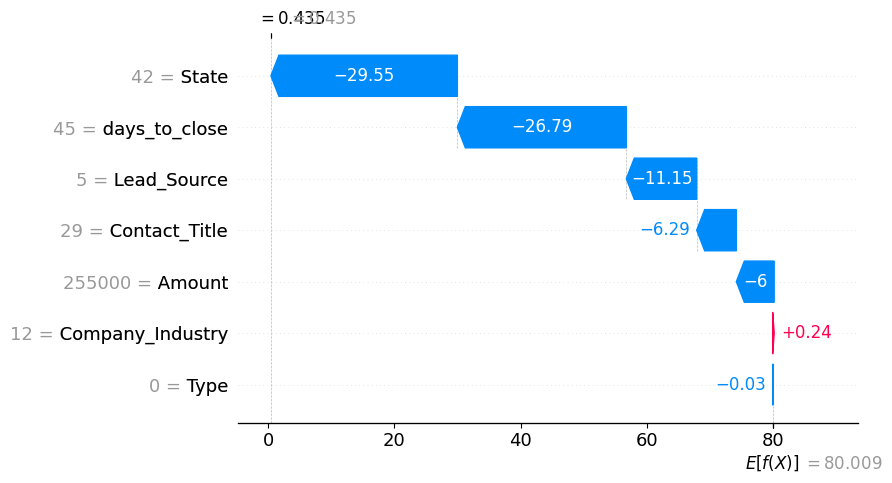

In [622]:
import shap 

explainer = shap.Explainer(xgb_model_train)
shap_values = explainer(X_train_new)
print(type(shap_values))
shap.plots.waterfall(shap_values[0])

In [623]:
print(shap_values)

.values =
array([[-5.99938822e+00,  2.36489370e-01, -6.28570604e+00,
        -3.36573720e-02, -1.11534910e+01, -2.95515766e+01,
        -2.67864666e+01],
       [-1.04248571e+00, -2.46281922e-01, -9.49417770e-01,
        -1.64217316e-02,  7.98873901e+00,  2.65593386e+00,
         1.15921564e+01],
       [-1.23517430e+00,  2.04723164e-01, -4.43313211e-01,
         7.21229464e-02, -1.93843102e+00,  9.36817646e-01,
         2.24198074e+01],
       [-1.23344696e+00,  2.03822449e-01, -1.02051842e+00,
         3.51894312e-02, -9.22088027e-01,  8.47606468e+00,
         1.44753599e+01],
       [-1.22291470e+00,  1.95969477e-01,  2.52156544e+00,
         3.51894312e-02, -5.90588868e-01,  7.53841400e+00,
         1.14883518e+01],
       [-2.09885046e-01,  2.56283432e-01, -1.15983343e+00,
        -1.34069286e-03,  1.35966272e+01,  8.61309433e+00,
        -9.67615962e-01],
       [-3.29554892e+00,  2.70031184e-01,  1.17190390e+01,
         7.21229464e-02, -1.80305171e+00, -1.03231668e+01,
        

In [624]:
import pandas as pd
importance_df = pd.DataFrame({
    "Feature": X_train_new.columns,
    "Mean SHAP Value": np.abs(shap_values.values).mean(axis=0)
}).sort_values(by="Mean SHAP Value", ascending=False)

print(importance_df)


            Feature  Mean SHAP Value
6     days_to_close        15.716165
4       Lead_Source         9.550630
5             State         8.198595
2     Contact_Title         3.138015
0            Amount         2.735488
1  Company_Industry         0.422181
3              Type         0.019282


### Export Feature Importance

In [625]:
# Create the folder if it doesn't exist
os.makedirs("3_salesforce_feature_importance_data", exist_ok=True)

# Save the Excel file inside the folder
importance_df.to_csv("3_salesforce_feature_importance_data/3_salesforce_feature_importance_data.csv", index=False)


In [626]:
# spark_df = spark.createDataFrame(importance_df)
# spark_df.write.mode("overwrite").saveAsTable("sd_bdc_demo.xgboost_regression.3_salesforce_feature_importance_data")